In [1]:
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

<Figure size 432x288 with 0 Axes>

# Defining the model
First, we define the model as a probabilistic program inheriting from `pyprob.Model`. Models inherit from `torch.nn.Module` and can be potentially trained with gradient-based optimization (not covered in this example).

The `forward` function can have any number and type of arguments as needed.

In [2]:
class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name='Gaussian with unknown mean (Marsaglia)') # give the model a name
        self.prior_mean = 1
        self.prior_stdd = math.sqrt(5)
        self.likelihood_stdd = math.sqrt(2)
        
    def marsaglia(self, mean, stddev):
        uniform = Uniform(-1, 1)
        s = 1
        while float(s) >= 1:
            x = pyprob.sample(uniform)
            y = pyprob.sample(uniform)
            s = x*x + y*y
        return mean + stddev * (x * torch.sqrt(-2 * torch.log(s) / s))

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        mu = self.marsaglia(self.prior_mean, self.prior_stdd)

        # define the likelihood
        likelihood = Normal(mu, self.likelihood_stdd)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables
        pyprob.observe(likelihood, name='obs1')

        # return the latent quantity of interest
        return mu
    
model = GaussianUnknownMean()

In [3]:
def construct_correct_posterior(model, observed_list):
    n = len(observed_list)
    posterior_var = 1/(n/model.likelihood_stdd**2 + 1/model.prior_stdd**2)
    posterior_mu = posterior_var * (1/model.prior_stdd**2 + 2*np.mean(observed_list)/2)
    p = Normal(posterior_mu, math.sqrt(posterior_var))
    return lambda x: math.exp(p.log_prob(x))

def prior_pdf(x):
    p = Normal(1,math.sqrt(5))
    return math.exp(p.log_prob(x))

def plot_pdf(min_val, max_val, pdf, *args, **kwargs):
    x = np.linspace(min_val,max_val,int((max_val-min_val)*50))
    plt.plot(x, np.vectorize(pdf)(x), *args, **kwargs)

def plot_correct_posterior(min_val, max_val, posterior_pdf):
    plot_pdf(min_val, max_val, posterior_pdf, label='correct posterior', color='orange')
    

def plot_prior(min_val, max_val):
    plot_pdf(min_val, max_val, prior_pdf, label='prior', color='green')

# Prior distribution
We inspect the prior distribution to see if it behaves in the way we intended. First we construct an `Empirical` distribution with forward samples from the model.

Note: Extra arguments passed to `prior_distribution` will be forwarded to model's `forward` function.

In [4]:
prior = model.prior_distribution(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1,983.56       


We can plot a historgram of these samples that are held by the `Empirical` distribution.

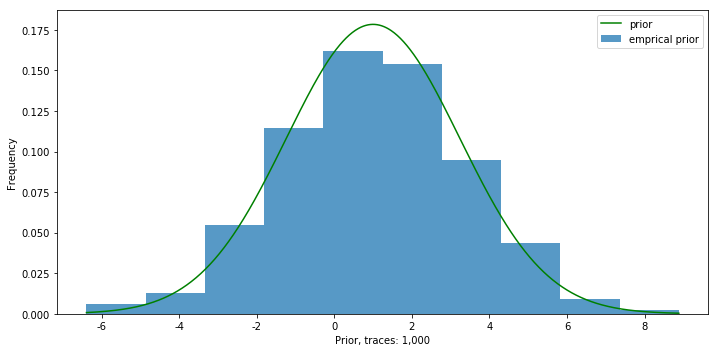

In [ ]:
prior.plot_histogram(show=False, alpha=0.75, label='emprical prior')
plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
plt.legend();

# Posterior inference with importance sampling
For a given set of observations, we can get samples from the posterior distribution.

In [ ]:
observed = [8, 9]
# sample from posterior (5000 samples)
posterior = model.posterior_distribution(
                                         num_traces=5000, # the number of samples estimating the posterior
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                                         observe={'obs0': observed[0],
                                                  'obs1': observed[1]} # assign values to the observed values
                                         )
# Correct posterior, computed analytically
correct_posterior = construct_correct_posterior(model, observed)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 5000/5000 | 2,140.53       


Regular importance sampling uses proposals from the prior distribution. We can see this by plotting the histogram of the posterior distribution without using the importance weights. As expected, this is the same with the prior distribution.

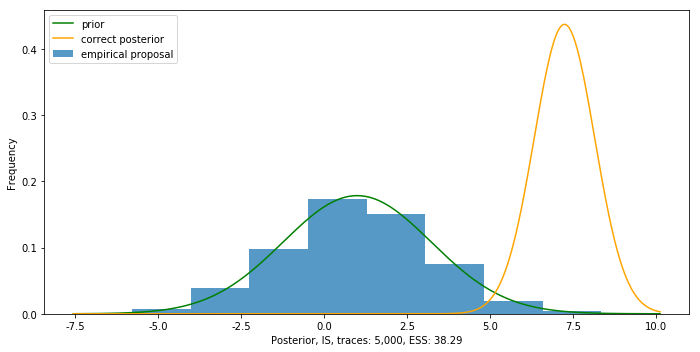

In [ ]:
posterior_unweighted = posterior.unweighted()
posterior_unweighted.plot_histogram(show=False, alpha=0.75, label='empirical proposal')
plot_prior(min(posterior_unweighted.values_numpy()), max(posterior_unweighted.values_numpy()))
plot_correct_posterior(min(posterior_unweighted.values_numpy()),
                       max(posterior_unweighted.values_numpy()), correct_posterior)
plt.legend();

When we do use the weights, we end up with the correct posterior distribution. The following shows the sampled posterior with the correct posterior (orange curve).

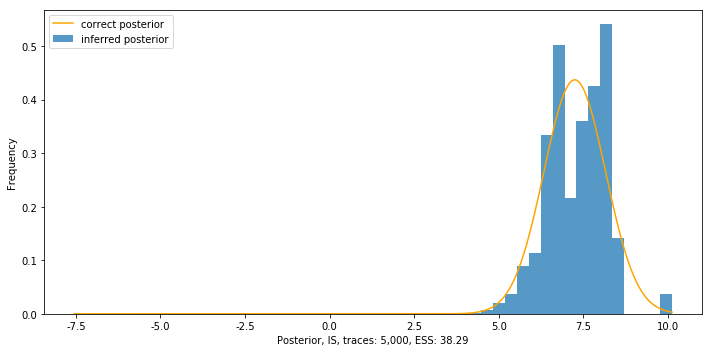

In [ ]:
posterior.plot_histogram(show=False, alpha=0.75, bins=50, label='inferred posterior')
plot_correct_posterior(min(posterior.values_numpy()),
                       max(posterior.values_numpy()), correct_posterior)
plt.legend();

In practice, it is advised to use methods of the `Empirical` posterior distribution instead of dealing with the weights directly, which ensures that the weights are used in the correct way.

For instance, we can get samples from the posterior, compute its mean and standard deviation, and evaluate expectations of a function under the distribution:

In [ ]:
print(posterior.sample())

tensor(6.3480)


In [ ]:
print(posterior.mean)

tensor(7.3206)


In [ ]:
print(posterior.stddev)

tensor(0.8764)


In [ ]:
print(posterior.expectation(lambda x: torch.sin(x)))

tensor(0.5998)


# Inference compilation
Inference compilation is a technique where a deep neural network is used for parameterizing the proposal distribution in importance sampling (https://arxiv.org/abs/1610.09900). This neural network, which we call inference network, is automatically generated and trained with data sampled from the model.

We can learn an inference network for our model.

In [ ]:
model.learn_inference_network(num_traces=50000,
                              observe_embeddings={'obs0' : {'dim': 64},
                                                  'obs1': {'dim': 64}})

Creating new inference network...
Generating validation batch...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: embedding depth not specified, using the default 2.
Observable obs1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs1: embedding depth not specified, using the default 2.
New proposal layer for address: 34__forward__marsaglia__x__Uniform__1
New proposal layer for address: 44__forward__marsaglia__y__Uniform__1
New proposal layer for address: 34__forward__marsaglia__x__Uniform__2
New proposal layer for address: 44__forward__marsaglia__y__Uniform__2
New proposal layer for address: 34__forward__marsaglia__x__Uniform__3
New proposal layer for address: 44__forward__marsaglia__y__Uniform__3
New proposal layer for address: 34__forward__marsaglia__x__Uniform__4
New proposal layer for address: 44__forward__marsaglia__y__Uniform__4
Total number of parameters: 427,412
Train. time | Trace     | Init. loss| M

We now construct the posterior distribution using samples from inference compilation, using the trained inference network.

A much smaller number of samples are enough (500 vs. 5000) because the inference network provides good proposals based on the given observations. We can see that the proposal distribution given by the inference network is doing a job much better than the prior, by plotting the posterior samples without the importance weights, for a selection of observations.

In [ ]:
# sample from posterior (200 samples)
posterior = model.posterior_distribution(
                                         num_traces=500, # the number of samples estimating the posterior
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                                         observe={'obs0': 8, 'obs1': 9} # assign values to the observed values
                                         )

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 500/500 | 115.45       


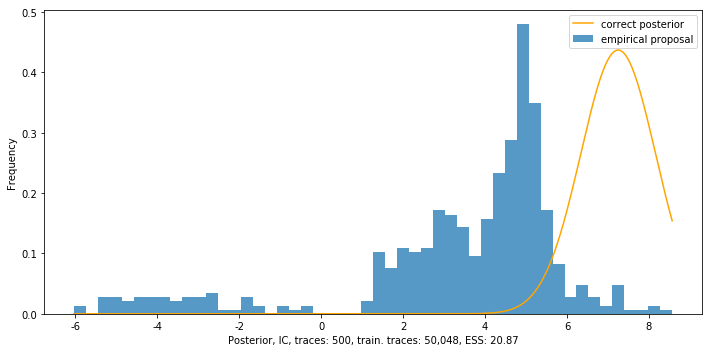

In [ ]:
posterior_unweighted = posterior.unweighted()
posterior_unweighted.plot_histogram(show=False, bins=50, alpha=0.75, label='empirical proposal')

plot_correct_posterior(min(posterior.values_numpy()),
                       max(posterior.values_numpy()), correct_posterior)
plt.legend();

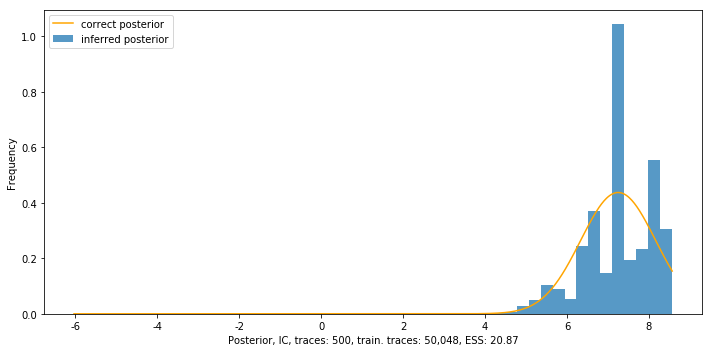

In [ ]:
posterior.plot_histogram(show=False, bins=50, alpha=0.75, label='inferred posterior')
plot_correct_posterior(min(posterior.values_numpy()),
                       max(posterior.values_numpy()), correct_posterior)
plt.legend();

Inference compilation performs amortized inferece which means, we do not need to train the same trained network provides proposal distributions for all observed values.

We can try performing inference using the same trained network with different observed values.

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:05 | 0d:00:00:00 | #################### | 500/500 | 86.14        


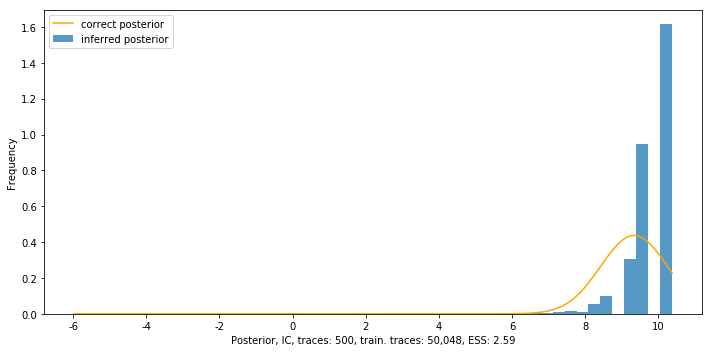

In [ ]:
observed = [12, 10]

correct_posterior = construct_correct_posterior(model, observed)

posterior = model.posterior_distribution(
                                         num_traces=500,
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                                         observe={'obs0': observed[0],
                                                  'obs1': observed[1]}
                                         )

posterior.plot_histogram(show=False, bins=50, alpha=0.75, label='inferred posterior')
plot_correct_posterior(min(posterior.values_numpy()),
                       max(posterior.values_numpy()), correct_posterior)
plt.legend();